In [7]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.signal import savgol_filter
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
import rioxarray

from func_processing import ts_telcirkel_per_jaar, bare_soil_calc, bare_soil_format


## Settings


In [8]:

vi_str = 'bsi' # van welke vegetatie-index analyse doen?

output_folder = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/rasters-telcirkels' #folder location of the rasters

path_2022 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2022_clip.gpkg'
path_2023 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2023_clip.gpkg'

#---- 
# Reading in all the parcels from Z-/Q-schijf and combining into one 
gdf_2022 = gpd.read_file(path_2022).to_crs(32631)
gdf_2023 = gpd.read_file(path_2023).to_crs(32631)
#----

# Dictionary met de geodataframes per jaar (aanpassen als je meer of minder jaren wilt, moet natuurlijk binnen het tijdsbereik waarvoor er rasters gedownload zijn)
analysis_years_dict = {2022: gdf_2022, 2023: gdf_2023}

## Bare soil analysis
Eerst de weggeschreven rasters terug inladen op de juiste manier (time index valt onder andere weg blijkbaar). Daarna op de ingeladen data de *bare soil analysis* doen. De analyse op de weggeschreven rasters doen gaat veel sneller dan het rechtstreeks uit te voeren wanneer de data van earth engine komt! De *bare soil analysis* moet per jaar apart gebeuren met de bijbehorende landbouwgebruikspercelen, terwijl de rasters gedownload zijn voor verschillenden jaren tegelijk. In deze analyse moet dus andere polygonen gebruikt worden afhankelijk van het jaar.

<Axes: >

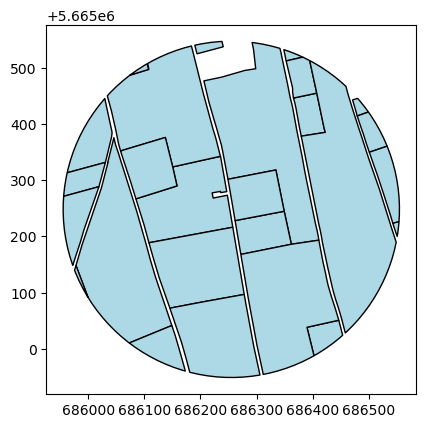

In [11]:
gdf_2022.head(5)


# CRS should be 4326
gdf_2022.loc[(gdf_2022.pointid == 'Km_26663.17')].plot(color='lightblue', edgecolor='black', linewidth=1)

In [10]:
#-- Aggregation of time series over polygons
# Create empty dataframe for storage results (polygon-aggregated time series)
df_ts = pd.DataFrame(columns=['REF_ID', 'pointid', 'time', 'ndvi'])

raster_files = os.listdir(output_folder)

for file in raster_files:
    print(file)
    
    # Open the raster file
    raster = rioxarray.open_rasterio(os.path.join(output_folder,file))

    # Extract dates from the 'long_name' attribute, convert to datetime & assign to 'band' coordinate
    dates = [raster.attrs['long_name'][i] for i in range(len(raster.band))]
    time_index = pd.to_datetime(dates)
    raster['band'] = time_index


    # Xarray settings
    raster = raster.rename({'band': 'time', 'x' : 'X', 'y': 'Y'}).transpose('time', 'X', 'Y')
    raster = raster.rio.set_spatial_dims('X','Y')
    raster.rio.write_crs("EPSG:32631", inplace=True)

    # Extract pointid
    # pointid moet overeenkomen met de raster waarvoor de data opgehaald wordt, anders probleem met geen overlap tussen raster en polygon
    parts = file.split('_')
    pointid = parts[3] + '_' + parts[4]
        
    # In deze for-loop worden de tijdsreeksen voor het telpunt per jaar apart toegevoegd; afhankelijk van de geodataframes die in de dictionary zitten
    for year, gdf_year in analysis_years_dict.items():
        df_ts = ts_telcirkel_per_jaar(raster=raster, gdf=gdf_year, year=year, pointid=pointid, df_ts=df_ts)

df_ts = df_ts.sort_values(by = ['pointid','REF_ID','time']).reset_index(drop=True)
df_ts = df_ts[['pointid', 'REF_ID', 'time', 'ndvi']]
df_ts.to_csv(f'../outputs/output_analysis/time_series_{vi_str}.csv')

df_ts

multiband_raster_bsi_Km_10015_sg.tif
multiband_raster_bsi_Km_10019_sg.tif
multiband_raster_ndvi_Km_10015_sg.tif
multiband_raster_ndvi_Km_10019_sg.tif
multiband_raster_ndvi_Km_10056.3_sg.tif
multiband_raster_ndvi_Km_10565.2.3_sg.tif
multiband_raster_ndvi_Km_10577.3_sg.tif
multiband_raster_ndvi_Km_10810.1_sg.tif
multiband_raster_ndvi_Lm_11070_sg.tif
multiband_raster_ndvi_Lm_11568.1_sg.tif
multiband_raster_ndvi_Lm_15064.9_sg.tif
multiband_raster_ndvi_Lm_8486.3_sg.tif
multiband_raster_ndvi_Lm_8898.1.8_sg.tif
multiband_raster_ndvi_Lm_9709.1.6_sg.tif
multiband_raster_ndvi_Zn_10111.7_sg.tif
multiband_raster_ndvi_Zn_10583.5_sg.tif
multiband_raster_ndvi_Zn_11411.7_sg.tif


,pointid,REF_ID,time,ndvi
0,Km_10015,403232939,2022-02-01,-0.025186
1,Km_10015,403232939,2022-02-11,-0.035797
2,Km_10015,403232939,2022-02-21,-0.036088
3,Km_10015,403232939,2022-03-03,-0.026603
4,Km_10015,403232939,2022-03-13,-0.000334
...,...,...,...,...
3659,Km_10019,2316533182,2023-07-16,-0.087652
3660,Km_10019,2316533182,2023-07-26,-0.096212
3661,Km_10019,2316533182,2023-08-05,-0.107203
3662,Km_10019,2316533182,2023-08-15,-0.106042


In [ ]:
# Do bare soil calculation on every year seperately

for year, gdf_year in analysis_years_dict.items():
    # Formatting before bare soil calculation
    # This format & the calculation should be changed if it turns out that it is too heavy for processing
    gdf_ts_year = bare_soil_format(df_ts, gdf_year, year)
    
    # Bare soil calculation
    result = bare_soil_calc(gdf_ts_year)

    result.to_csv(f'../outputs/output_analysis/bare_soil_analysis_{year}_v3.csv')

result.head(5)
#gdf_ts[['OIDN', 'pointid', 'date', 'ndvi','geometry']].head(3)
#gdf.loc[~gdf.OIDN.isin(gdf_ts.OIDN.unique().tolist())].to_file('../outputs/empty_geometries.gpkg')